In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\Welcome\Downloads\NeoLung-main\Dataset\survey lung cancer.csv")


In [3]:
print("Dataset shape:", df.shape)
print("\nSample data:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nClass distribution:")
print(df['LUNG_CANCER'].value_counts())

Dataset shape: (309, 16)

Sample data:
  GENDER  AGE  SMOKING  YELLOW_FINGERS  ANXIETY  PEER_PRESSURE  \
0      M   69        1               2        2              1   
1      M   74        2               1        1              1   
2      F   59        1               1        1              2   
3      M   63        2               2        2              1   
4      F   63        1               2        1              1   

   CHRONIC DISEASE  FATIGUE  ALLERGY  WHEEZING  ALCOHOL CONSUMING  COUGHING  \
0                1        2        1         2                  2         2   
1                2        2        2         1                  1         1   
2                1        2        1         2                  1         2   
3                1        1        1         1                  2         1   
4                1        1        1         2                  1         2   

   SHORTNESS OF BREATH  SWALLOWING DIFFICULTY  CHEST PAIN LUNG_CANCER  
0                

In [4]:
label_encoder = LabelEncoder()
df['LUNG_CANCER_ENCODED'] = label_encoder.fit_transform(df['LUNG_CANCER'])
print("\nEncoded target:")
print(df['LUNG_CANCER_ENCODED'].value_counts())
print(f"Class mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")


Encoded target:
LUNG_CANCER_ENCODED
1    270
0     39
Name: count, dtype: int64
Class mapping: {'NO': 0, 'YES': 1}


In [5]:
X = df.drop(['LUNG_CANCER', 'LUNG_CANCER_ENCODED'], axis=1)
y = df['LUNG_CANCER_ENCODED']

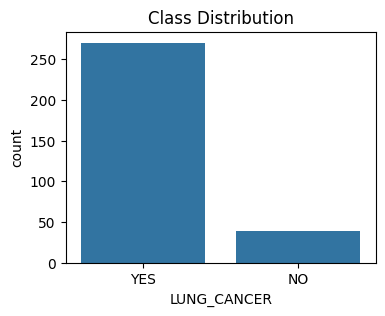

In [8]:
plt.figure(figsize=(4, 3))
sns.countplot(x=df['LUNG_CANCER'])
plt.title('Class Distribution')
plt.show()

In [9]:
X['GENDER'] = X['GENDER'].map({'M': 1, 'F': 0})

# Convert all 1/2 values to 0/1 values (assuming 1=No, 2=Yes)
binary_columns = ['SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE',
                  'CHRONIC DISEASE', 'FATIGUE', 'ALLERGY', 'WHEEZING', 
                  'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
                  'SWALLOWING DIFFICULTY', 'CHEST PAIN']

for col in binary_columns:
    X[col] = X[col].map({1: 0, 2: 1})  # Convert 1->0 and 2->1

# Display feature statistics
print("\nFeature statistics:")
print(X.describe())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)



Feature statistics:
           GENDER         AGE     SMOKING  YELLOW_FINGERS     ANXIETY  \
count  309.000000  309.000000  309.000000      309.000000  309.000000   
mean     0.524272   62.673139    0.563107        0.569579    0.498382   
std      0.500221    8.210301    0.496806        0.495938    0.500808   
min      0.000000   21.000000    0.000000        0.000000    0.000000   
25%      0.000000   57.000000    0.000000        0.000000    0.000000   
50%      1.000000   62.000000    1.000000        1.000000    0.000000   
75%      1.000000   69.000000    1.000000        1.000000    1.000000   
max      1.000000   87.000000    1.000000        1.000000    1.000000   

       PEER_PRESSURE  CHRONIC DISEASE     FATIGUE     ALLERGY    WHEEZING  \
count     309.000000       309.000000  309.000000  309.000000  309.000000   
mean        0.501618         0.504854    0.673139    0.556634    0.556634   
std         0.500808         0.500787    0.469827    0.497588    0.497588   
min         0

In [10]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Print best parameters
print("\nBest parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate the model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Confusion Matrix:
[[11  1]
 [ 6 75]]


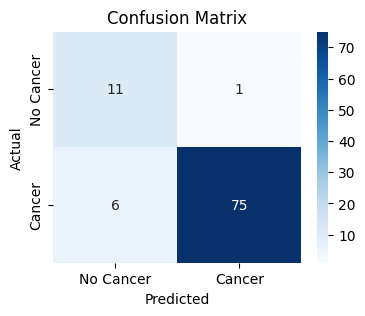

In [11]:
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Cancer', 'Cancer'],
            yticklabels=['No Cancer', 'Cancer'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [12]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Cancer', 'Cancer']))

print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))



Classification Report:
              precision    recall  f1-score   support

   No Cancer       0.65      0.92      0.76        12
      Cancer       0.99      0.93      0.96        81

    accuracy                           0.92        93
   macro avg       0.82      0.92      0.86        93
weighted avg       0.94      0.92      0.93        93


ROC AUC Score: 0.955761316872428


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy : " , accuracy_score(y_test, y_pred))


Accuracy :  0.9247311827956989



Feature Importance:
                  Feature  Importance
8                 ALLERGY    0.168754
10      ALCOHOL CONSUMING    0.145659
1                     AGE    0.108915
13  SWALLOWING DIFFICULTY    0.085946
5           PEER_PRESSURE    0.078787
11               COUGHING    0.056979
9                WHEEZING    0.052782
4                 ANXIETY    0.052422
7                 FATIGUE    0.050303
3          YELLOW_FINGERS    0.047969
12    SHORTNESS OF BREATH    0.036872
14             CHEST PAIN    0.035498
6         CHRONIC DISEASE    0.034995
0                  GENDER    0.022500
2                 SMOKING    0.021619


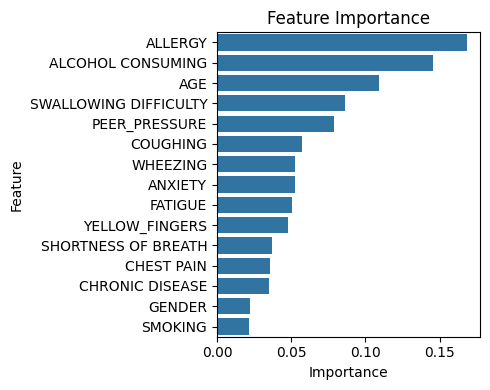

In [13]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

plt.figure(figsize=(5, 4))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [14]:
with open('lung_cancer_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

print("\nModel saved as 'lung_cancer_model.pkl'")

# Create a reference dataframe with the exact feature names used in training
feature_ref = pd.DataFrame(columns=X.columns)
with open('feature_reference.pkl', 'wb') as ref_file:
    pickle.dump(feature_ref, ref_file)

print("\nFeature reference saved as 'feature_reference.pkl'")


Model saved as 'lung_cancer_model.pkl'

Feature reference saved as 'feature_reference.pkl'
